In [219]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random

(-0.5, 799.5, 639.5, -0.5)

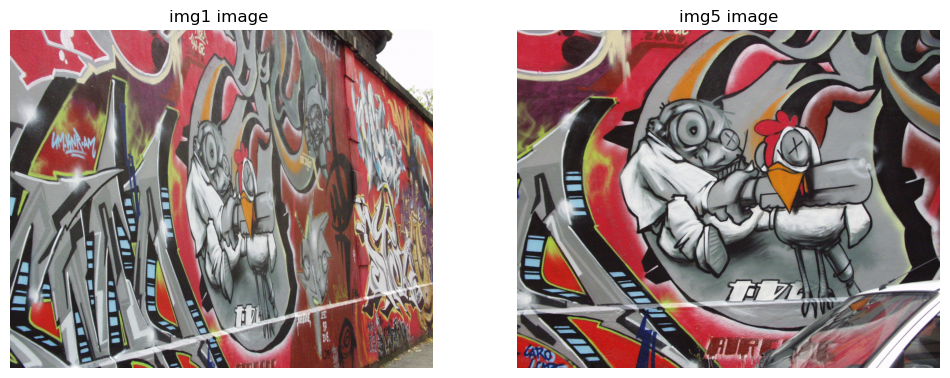

In [237]:
img1 = cv.imread('../../graf/img5.ppm')
img5 = cv.imread('../../graf/img1.ppm')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1 image ')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5 image')
plt.axis('off')



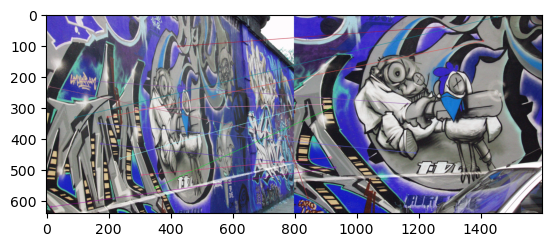

(<matplotlib.image.AxesImage at 0x250977a8ee0>, None)

In [249]:
# Convert images to grayscale
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

# Create a SIFT detector
sift = cv.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp5, des5 = sift.detectAndCompute(gray5, None)

# Use BFMatcher to find the best matches between descriptors
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)

# Apply ratio test to retain good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.60* n.distance:  # Lowe's ratio test
        good_matches.append(m)

# Draw matches between img1 and img5 (for visualization)
img_matches = cv.drawMatches(img1, kp1, img5, kp5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches), plt.show()

In [246]:
# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Helper function to normalize points (centroid shift and scaling)
def normalize_points(points):
    centroid = np.mean(points, axis=0)
    shifted_points = points - centroid
    scale = np.sqrt(2) / np.mean(np.linalg.norm(shifted_points, axis=1))
    normalized_points = shifted_points * scale
    
    # Create transformation matrix to apply to the points
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])
    
    return normalized_points, T

# Function to compute homography using the DLT algorithm
def compute_homography(src_pts, dst_pts):
    # Normalize the points
    src_pts, T_src = normalize_points(src_pts)
    dst_pts, T_dst = normalize_points(dst_pts)
    
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
        A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])
    
    A = np.array(A)
    
    # Perform SVD to solve for H (homography matrix)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    
    # Denormalize the homography matrix
    H = np.dot(np.linalg.inv(T_dst), np.dot(H, T_src))
    
    return H / H[-1, -1]  # Normalize so that H[2, 2] = 1

# Function to calculate the reprojection error
def reprojection_error(H, src_pts, dst_pts):
    src_pts_h = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    dst_proj = np.dot(H, src_pts_h.T).T
    dst_proj = dst_proj[:, :2] / dst_proj[:, 2].reshape(-1, 1)
    
    # Return the Euclidean distance between the projected points and the actual points
    return np.linalg.norm(dst_pts - dst_proj, axis=1)

# RANSAC for Homography estimation
def ransac_homography(src_pts, dst_pts, num_iter=1000, threshold=5.0):
    best_H = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(num_iter):
        # Randomly sample 4 points
        sample_indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[sample_indices]
        dst_sample = dst_pts[sample_indices]
        
        # Compute homography using the DLT algorithm
        H = compute_homography(src_sample, dst_sample)
        
        # Compute reprojection error for all points
        errors = reprojection_error(H, src_pts, dst_pts)
        
        # Find inliers
        inliers = errors < threshold
        num_inliers = np.sum(inliers)
        
        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_H = H
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_H, best_inliers

# Example usage:
# Assuming `src_pts` and `dst_pts` are your matched point correspondences

# src_pts and dst_pts should be in shape (N, 2) where N is the number of correspondences
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])  # Source points (from the first image)
dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches])  # Destination points (from the second image)

# Compute the homography using RANSAC
H, inliers = ransac_homography(src_pts, dst_pts)

print("Homography matrix computed using RANSAC:")
print(H)

Homography matrix computed using RANSAC:
[[ 1.58729232e-01 -6.50094264e-01  1.37379433e+02]
 [ 6.53387778e-01 -2.39020355e+00  4.91756071e+02]
 [ 1.29929738e-03 -4.85175492e-03  1.00000000e+00]]


In [217]:
H =  np.array([[6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
   [2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
   [4.9212545e-04,  -3.6542424e-05 ,  1.0000000e+00]])

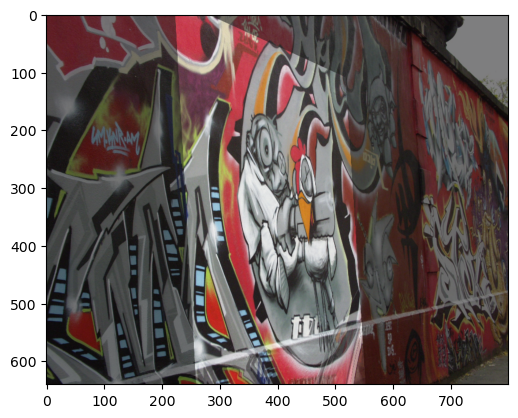

(<matplotlib.image.AxesImage at 0x250985e27f0>, None)

In [218]:
# Warp img1 to align with img5 using the homography matrix
h, w, _ = img5.shape
img1_warped = cv.warpPerspective(img1, H, (w, h))

# Create a blank canvas to hold the stitched image
stitched_image = np.zeros_like(img1_warped)
stitched_image[:h, :w] = img5

# Stitch the warped image1 onto the canvas
alpha = 0.5  # Blending factor to smooth the transition
stitched_image = cv.addWeighted(stitched_image, alpha, img1_warped, 1 - alpha, 0)

# Show the final stitched image
plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB)), plt.show()

   6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00
